# Refinement of EBSD patterns from an Al-Mn alloy

Håkon Wiik Ånes (hakon.w.anes@ntnu.no)

See the relevant package documentation for more details on the packages used here:
* kikuchipy: https://kikuchipy.org/en/stable/
* orix: https://orix.readthedocs.io/en/stable/

Import required packages and print their versions

In [1]:
# Replace "inline" with "qt5" from the pyqt package for interactive plotting
%matplotlib inline

from datetime import date
import importlib_metadata
import os

import kikuchipy as kp
import matplotlib.pyplot as plt
import numpy as np
from orix import io, plot
from orix.vector import Vector3d


# Directories
dset_no = 1
dir_user = "C:/Users/hakonwii"
dir_mp = os.path.join(dir_user, "ebsd_simulations")
dir_data = os.path.join(dir_user, "p/300c", str(dset_no))

savefig_kwds = dict(bbox_inches="tight", pad_inches=0, dpi=150)
suffix = "refori"

print("Run date: ", date.today())
print("\nSoftware versions\n------------------")
for pkg in ["kikuchipy", "matplotlib", "numpy", "orix"]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

Run date:  2022-05-12

Software versions
------------------
kikuchipy : 0.5.7
matplotlib : 3.5.2
numpy : 1.21.6
orix : 0.8.2


## Set up refinement

Load data (lazily)

In [2]:
s = kp.load(os.path.join(dir_data, "pattern_sda.h5"), lazy=True)
sig_shape = s.axes_manager.signal_shape[::-1]
print(s.axes_manager)

<Axes manager, axes: (919, 919|96, 96)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    919 |      0 |       0 |     0.1 |     um 
               y |    919 |      0 |       0 |     0.1 |     um 
---------------- | ------ | ------ | ------- | ------- | ------ 
              dx |     96 |      0 |       0 |       1 |     um 
              dy |     96 |      0 |       0 |       1 |     um 


Extract relevant metadata

In [3]:
md_sem = s.metadata.Acquisition_instrument.SEM
md_ebsd = md_sem.Detector.EBSD
sample_tilt = md_ebsd.sample_tilt  # Degrees
camera_tilt = md_ebsd.azimuth_angle  # Degrees
energy = md_sem.beam_energy  # kV

Define detector's view of the sample, using the average projection center (PC)
found from optimization with `PyEBSDIndex`

In [4]:
pcs = np.loadtxt(os.path.join(dir_data, "cal_pcs.txt"), usecols=[1, 2, 3])
pc = pcs.mean(axis=0)
print(pc)

detector = kp.detectors.EBSDDetector(
    shape=sig_shape,
    pc=pc,
    sample_tilt=sample_tilt,
    tilt=camera_tilt,
    convention="bruker",
)
detector

[0.49789041 0.22546632 0.5497445 ]


EBSDDetector (96, 96), px_size 1 um, binning 1, tilt 0.0, azimuthal 0, pc (0.498, 0.225, 0.55)

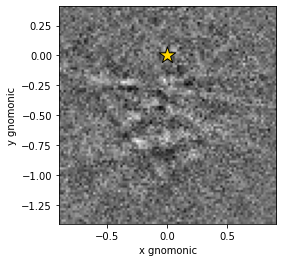

In [5]:
fig, _ = detector.plot(coordinates="gnomonic", pattern=s.inav[0, 0].data.compute(), return_fig_ax=True)
fig.savefig(os.path.join(dir_data, f"detector_{suffix}.png"), **savefig_kwds)

Load master pattern

In [6]:
mp = kp.load(
    os.path.join(dir_mp, "al", "al_mc_mp_20kv.h5"),
    projection="lambert",
    energy=energy,
    hemisphere="north",
)
mp.phase.name = "al"

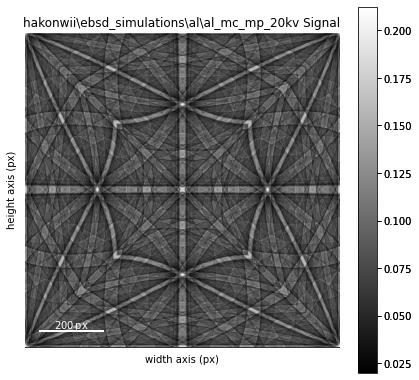

In [7]:
mp.plot()

Load DI results

In [8]:
xmap = io.load(os.path.join(dir_data, "xmap.h5"))
xmap

Phase     Orientations  Name  Space group  Point group  Proper point group     Color
    0  844561 (100.0%)    al        Fm-3m         m-3m                 432  tab:blue
Properties: scores, simulation_indices
Scan unit: px

## Refinement

In [9]:
xmap_refined = s.refine_orientation(
    xmap=xmap,
    detector=detector,
    master_pattern=mp,
    energy=energy,
    compute=True,
)

Refinement information:
	Local optimization method: Nelder-Mead (minimize)
	Keyword arguments passed to method: {'method': 'Nelder-Mead'}
Refining 844561 orientation(s):
[########################################] | 100% Completed |  6hr 41min 47.8s
Refinement speed: 35 patterns/s


In [10]:
io.save(os.path.join(dir_data, f"xmap_{suffix}.h5"), xmap_refined)

## Inspect results

Normalized cross correlation scores

In [11]:
scores1d_di = xmap.scores[:, 0]
scores2d_di = scores1d_di.reshape(xmap.shape)

In [12]:
scores1d = xmap_refined.scores
scores2d = scores1d.reshape(xmap_refined.shape)

In [13]:
plt.imsave(os.path.join(dir_data, f"maps_ncc_{suffix}.png"), arr=scores2d, cmap="gray")

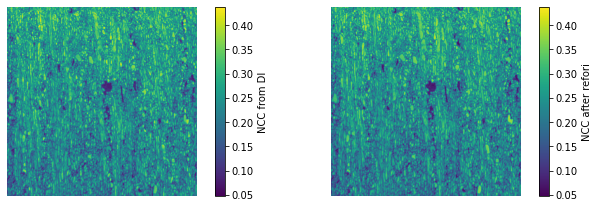

In [14]:
ncc_di_min = np.min(scores1d)
ncc_di_max = np.max(scores1d)
ncc_ori_ref_min = np.min(scores1d_di)
ncc_ori_ref_max = np.max(scores1d_di)

vmin = min([ncc_di_min, ncc_ori_ref_min])
vmax = max([ncc_di_max, ncc_ori_ref_max])

ncc_after_label = f"NCC after {suffix}"

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
im0 = ax[0].imshow(scores2d_di, vmin=vmin, vmax=vmax)
im1 = ax[1].imshow(scores2d, vmin=vmin, vmax=vmax)
fig.colorbar(im0, ax=ax[0], label="NCC from DI")
fig.colorbar(im1, ax=ax[1], label=ncc_after_label)
for a in ax:
    a.axis("off")
fig.tight_layout(w_pad=-1)
fig.savefig(os.path.join(dir_data, f"maps_ncc_comparison_{suffix}.png"), **savefig_kwds)

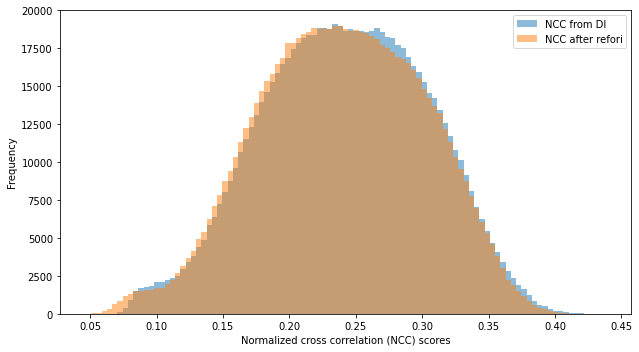

In [15]:
bins = np.linspace(vmin, vmax, 100)

fig, ax = plt.subplots(figsize=(9, 5))
ax.hist(scores1d_di, bins, alpha=0.5, label="NCC from DI");
ax.hist(scores1d, bins, alpha=0.5, label=ncc_after_label);
ax.set_xlabel("Normalized cross correlation (NCC) scores")
ax.set_ylabel("Frequency")
ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(dir_data, f"hist_ncc_comparison_{suffix}.png"), **savefig_kwds)

Orientation map comparison

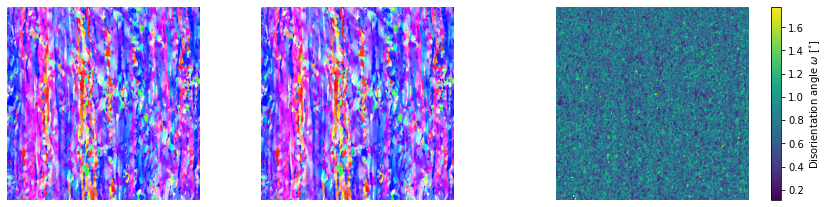

In [16]:
ori = xmap.orientations
ori_ref = xmap_refined.orientations

ckey = plot.IPFColorKeyTSL(xmap.phases[0].point_group)
ckey.direction = Vector3d.xvector()
rgb_z = ckey.orientation2color(ori)
rgb_z_ref = ckey.orientation2color(ori_ref)

mori_angle = np.rad2deg(ori.angle_with(ori_ref).data)
vmin, vmax = np.percentile(mori_angle, q=(1, 99))

fig, ax = plt.subplots(ncols=3, figsize=(14, 3))
ax[0].imshow(rgb_z.reshape(xmap.shape + (3,)))
ax[1].imshow(rgb_z_ref.reshape(xmap.shape + (3,)))
im2 = ax[2].imshow(mori_angle.reshape(xmap.shape), vmin=vmin, vmax=vmax)
fig.colorbar(im2, ax=ax[2], label=r"Disorientation angle $\omega$ [$^{\circ}$]")
for a in ax:
    a.axis("off")
fig.tight_layout(w_pad=-15)
fig.savefig(os.path.join(dir_data, f"maps_ipfx_comparison_{suffix}.png"), **savefig_kwds)

Histogram of misorientation angle between DI and refinement orientations

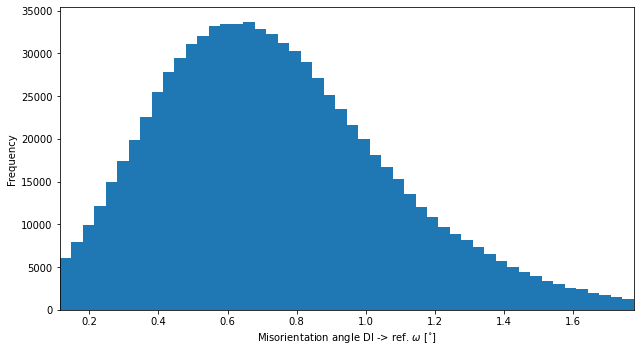

In [17]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.hist(mori_angle, bins=50, range=(vmin, vmax))
ax.set_xlim((vmin, vmax))
ax.set_xlabel("Misorientation angle DI -> ref. $\omega$ [$^{\circ}$]")
ax.set_ylabel("Frequency")
fig.tight_layout()
fig.savefig(os.path.join(dir_data, f"mori_angle_di_{suffix}.png"), **savefig_kwds)

Orientation maps

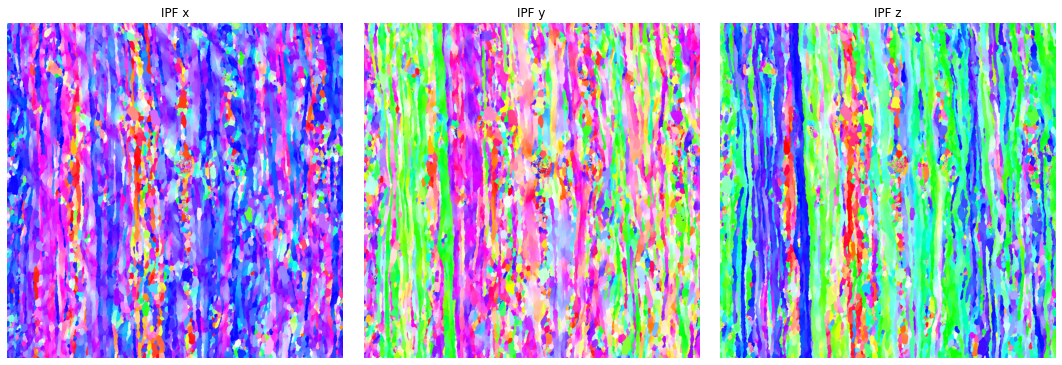

In [18]:
directions = Vector3d(((1, 0, 0), (0, 1, 0), (0, 0, 1)))
map_shape = xmap_refined.shape

fig, axes = plt.subplots(figsize=(15, 5), ncols=3)
for ax, v, title in zip(axes, directions, ("x", "y", "z")):
    ckey.direction = v
    rgb = ckey.orientation2color(ori_ref).reshape(map_shape + (3,))
    plt.imsave(os.path.join(dir_data, f"maps_ipf{title}_{suffix}.png"), rgb)
    ax.imshow(rgb)
    ax.axis("off")
    ax.set_title(f"IPF {title}")
fig.tight_layout()
fig.savefig(os.path.join(dir_data, f"maps_ipf_{suffix}.png"), **savefig_kwds)